In [504]:
import pandas as pd
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score,f1_score, roc_auc_score, recall_score, mean_squared_error

In [505]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\breast_cancer')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\breast_cancer'

In [506]:
pd.options.display.max_columns = 100

# Data

## Importing

In [507]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv',low_memory=False)
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,...,prkacg_mut,rpgr_mut,large1_mut,foxp1_mut,clk3_mut,prkcz_mut,lipi_mut,ppp2r2a_mut,prkce_mut,gh1_mut,gpr32_mut,kras_mut,nf2_mut,chek2_mut,ldlrap1_mut,clrn2_mut,acvrl1_mut,agtr2_mut,cdkn2a_mut,ctnna1_mut,magea8_mut,prr16_mut,dtwd2_mut,akt2_mut,braf_mut,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,-0.4294,-1.1201,-0.4844,-0.7483,-1.6660,-0.1250,-0.3721,-0.6508,-0.1278,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,0.5120,0.4390,1.2266,0.7612,0.1821,1.0104,0.5600,-0.4018,-0.2909,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,0.2362,-0.1721,-1.7910,3.0955,0.6608,2.6127,2.5553,-0.0391,-0.4421,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,1.0078,-0.4010,-1.3905,4.8798,0.0615,2.9414,4.1161,-0.3098,-1.3470,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,-0.2961,0.6320,-0.3582,0.3032,0.8747,0.6323,0.3349,-0.2652,-0.1541,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [508]:
df.columns[:31] #columns without gene and mutation info

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

### Dropping nan values

In [509]:
#findind nan values
df.isna().sum().sort_values(ascending=False)[:10]

tumor_stage                  501
3-gene_classifier_subtype    204
primary_tumor_laterality     106
neoplasm_histologic_grade     72
cellularity                   54
mutation_count                45
er_status_measured_by_ihc     30
type_of_breast_surgery        22
tumor_size                    20
cancer_type_detailed          15
dtype: int64

In [510]:
#deleting columns that aren't of particular interest and have many nan entries
#del df['3-gene_classifier_subtype']
del df['cellularity']
del df['neoplasm_histologic_grade']
del df['primary_tumor_laterality']
del df['er_status_measured_by_ihc']

In [511]:
#findind nan values
df.isna().sum().sort_values(ascending=False)[:10]

tumor_stage                       501
3-gene_classifier_subtype         204
mutation_count                     45
type_of_breast_surgery             22
tumor_size                         20
cancer_type_detailed               15
tumor_other_histologic_subtype     15
oncotree_code                      15
death_from_cancer                   1
akr1c2                              0
dtype: int64

In [512]:
#dropping nan values 
print(df.shape)
df = df.dropna()
print(df.shape)

(1904, 689)
(1185, 689)


In [513]:
# in cancer_type feature, one instance of Breast Sarcoma was deleted
# feature now only contains one value and is therefore removed 

df.pop('cancer_type');

In [514]:
#we also don't care about patient id 
df.pop('patient_id');

### Encoding data

In [515]:
#encoding binary features 
df = pd.get_dummies(df, columns=['type_of_breast_surgery','er_status','inferred_menopausal_state','pr_status','her2_status'], drop_first=True)

In [516]:
#replace mutant subtypes with wild type (0) or general mutant type (1)
for col in df.columns:
    if 'mut' in col:
        df[col]=np.where((df[col])!='0',1,0)

In [517]:
#removing mutant features with less than 30 positive instances 
for col in df.columns:
    if 'mut' in col:
        if sum(df[col]) < 30:
            del df[col]

In [518]:
#switching 0 and 1 so that 1 predicts death and 0 predicts survival
df['overall_survival']=np.where(df['overall_survival']==0,1,0)
#checking
df[['overall_survival','death_from_cancer']].head()

,overall_survival,death_from_cancer
1,0,Living
4,1,Died of Disease
5,1,Died of Disease
8,1,Died of Other Causes
9,1,Died of Disease


In [519]:
#encoding other features
df = pd.get_dummies(df, columns=['3-gene_classifier_subtype','death_from_cancer','cancer_type_detailed','pam50_+_claudin-low_subtype','cohort','integrative_cluster','oncotree_code','her2_status_measured_by_snp6','tumor_other_histologic_subtype'])
df.shape

(1185, 610)

### Removing outliers

In [520]:
#finding outliers
#we look through non-binary data to find outliers 
#looking through this list it does indeed appear that the categorical columns identified contain outliers 
#The gene expression values are more ambigous 

stats.zscore(df, axis=0).max(axis=0).sort_values(ascending=False)[:10]

pam50_+_claudin-low_subtype_NC        24.320773
lipi                                  20.703269
her2_status_measured_by_snp6_UNDEF    19.849433
nrg3                                  16.191813
ush2a                                 15.161436
gh1                                   15.156411
slco1b3                               14.980536
itgb3                                 14.888723
inha                                  14.568444
bmp3                                  13.883653
dtype: float64

In [521]:
#outliers with a z score above 20 are removed 
#this conservative approach is taken in order to only remove outliers from categorical data
#high gene expression levels could be a result of cancer causing phenotypes that are indeed different from the mean distribution and not outliers

zscore = stats.zscore(df, axis=0)
print(df.shape)
df[zscore>20]=np.nan
df.dropna(inplace=True)
df.shape

(1185, 610)


(1182, 610)

### Scaling data

In [522]:
#selecting features that will be scaled 
to_scale = [col for col in df if df[col].unique().shape[0] > 2]
not_scaled = [col for col in df if df[col].unique().shape[0] <= 2]

In [523]:
#normalizing features 
#I believe I have found a glitch with column transformer using dataframes and passthrough
#passthrough is not honored and all columns are transformed 
#thus, column transformer is not used and columns are manually transformed

#transforming to_scale columns
scaler = StandardScaler()
df_transformed = df[to_scale]
col_names = df_transformed.columns.values
df_transformed = scaler.fit_transform(df_transformed)
df_transformed = pd.DataFrame(df_transformed,columns=col_names)

#isolating passthrough columns
df_pass = df[not_scaled]

#concatenating df
df = pd.concat([df_transformed.reset_index(drop=True), df_pass.reset_index(drop=True)],axis=1)


## EDA

### Mortality

In [524]:
#constructs death classification column from encoded data
df_death = pd.from_dummies(df[df.columns[df.columns.str.contains('death_from_cancer')]])
df_death = df_death.replace({'death_from_cancer_Living':'Living','death_from_cancer_Died of Disease':'Cancer death','death_from_cancer_Died of Other Causes':'Other death'})

<Axes: ylabel='Count'>

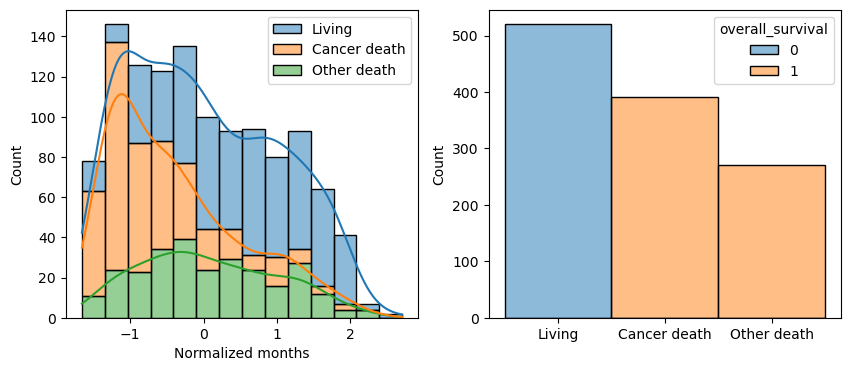

In [525]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='overall_survival_months',hue=df_death.iloc[:,0], multiple='stack',kde=True)
plt.xlabel('Normalized months')

plt.subplot(1,2,2)
#plt.bar(x = ['Cancer death','Other Death','Living'], height=df[['death_from_cancer_Died of Disease','death_from_cancer_Died of Other Causes', 'death_from_cancer_Living']].sum())
sns.histplot(data=df_death, x=df_death.iloc[:,0], hue=df['overall_survival'])

In [526]:
#remove other death indicators from dataset and focus on overall survival 
del df['death_from_cancer_Died of Disease']
del df['death_from_cancer_Died of Other Causes']
del df['death_from_cancer_Living']
del df['overall_survival_months']

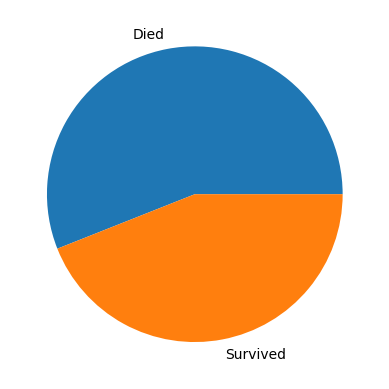

In [527]:
plt.pie(((sum(df['overall_survival']),df.shape[0]-sum(df['overall_survival']))),labels=['Died','Survived']);

### Age

<Axes: xlabel='age_at_diagnosis', ylabel='Count'>

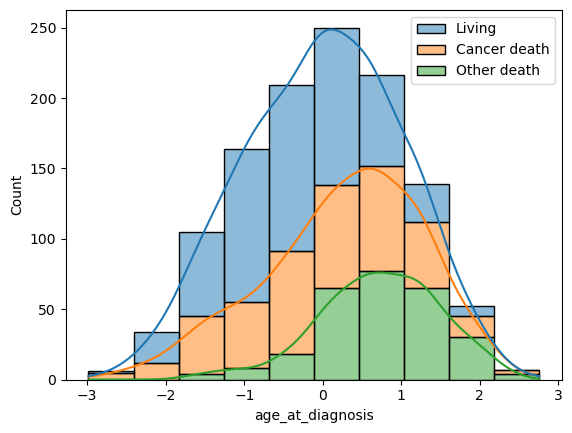

In [528]:
sns.histplot(data=df, x='age_at_diagnosis',hue=df_death.iloc[:,0],kde=True, bins=10, multiple='stack')

### Cancer sub-type

In [529]:
df.columns[df.columns.str.contains('3')]

Index(['tp53', 'e2f3', 'stat3', 'tp53bp1', 'dll3', 'dtx3', 'ep300', 'maml3',
       'notch3', 'bmp3', 'casp3', 'diras3', 'erbb3', 'folr3', 'foxo3', 'gsk3b',
       'itgb3', 'map2k3', 'map3k1', 'map3k3', 'map3k4', 'map3k5', 'mapk3',
       'mmp13', 'mmp23b', 'mmp3', 'peg3', 'pik3ca', 'pik3r1', 'pik3r2',
       'smad3', 'tgfb3', 'tgfbr3', 'gata3', 'tbx3', 'bbc3', 'cyp3a4',
       'slco1b3', 'bcas3', 'cacna2d3', 'ccnd3', 'clk3', 'col6a3', 'ctnna3',
       'flt3', 'frmd3', 'gpr32', 'kdm3a', 'lamb3', 'map3k10', 'map3k13',
       'myo3a', 'ncoa3', 'nr3c1', 'nrg3', 'sf3b1', 'zfp36l1', 'ackr3',
       'akr1c3', 'akt3', 'cyp3a43', 'cyp3a5', 'cyp3a7', 'hsd17b13', 'hsd17b3',
       'hsd3b1', 'hsd3b2', 'hsd3b7', 'pik3r3', 'srd5a3', 'pik3ca_mut',
       'tp53_mut', 'gata3_mut', 'map3k1_mut', 'tbx3_mut', 'col6a3_mut',
       'lamb3_mut', 'sf3b1_mut', 'ep300_mut', 'erbb3_mut',
       '3-gene_classifier_subtype_ER+/HER2- High Prolif',
       '3-gene_classifier_subtype_ER+/HER2- Low Prolif',
       '3-

([<matplotlib.axis.XTick at 0x20ed72510c0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

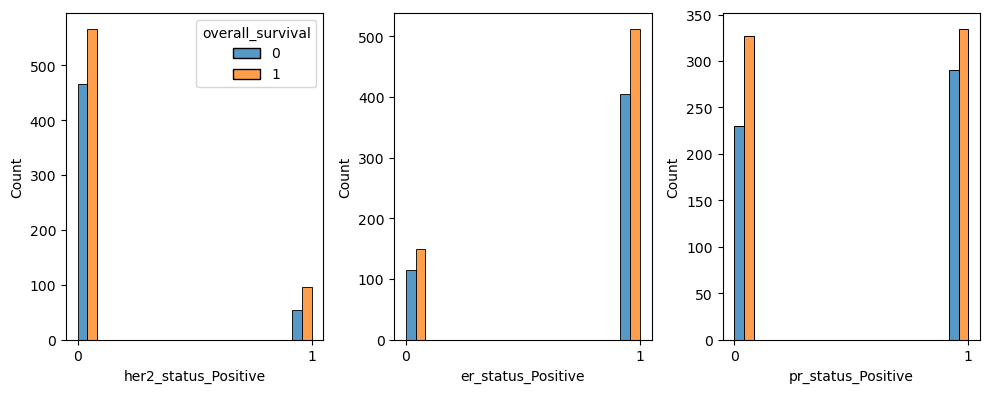

In [530]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
sns.histplot(data=df.sort_values('her2_status_Positive'), x='her2_status_Positive',hue='overall_survival',multiple='dodge')
plt.xticks((0,1))
plt.subplot(1,3,2)
sns.histplot(data=df.sort_values('er_status_Positive'), x='er_status_Positive', hue='overall_survival',multiple='dodge',legend=False)
plt.xticks((0,1))
plt.tight_layout()
plt.subplot(1,3,3)
sns.histplot(data=df.sort_values('pr_status_Positive'), x='pr_status_Positive', hue='overall_survival',multiple='dodge',legend=False)
plt.xticks((0,1))

In [531]:
df_gene = df[['3-gene_classifier_subtype_ER+/HER2- High Prolif','3-gene_classifier_subtype_ER+/HER2- Low Prolif','3-gene_classifier_subtype_ER-/HER2-','3-gene_classifier_subtype_HER2+']]
df_gene

,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
1177,0,1,0,0
1178,0,1,0,0
1179,0,0,1,0
1180,1,0,0,0


### Cancer severity


| Stage | Description |
| ----- | ---------------------------------------|
| 0 | Abnormal cells present with the potential to become cancer. |
| 1 | Cancer is only in original location and has not spread into neighboring tissue. Surgery can normaly remove the entire tumor. |
| 2 - 3 | Cancer is larger and has grown into nearby tissue or lymph nodes. |
| 4 | Advanced/metastatic cancer that has spread to other organs. |


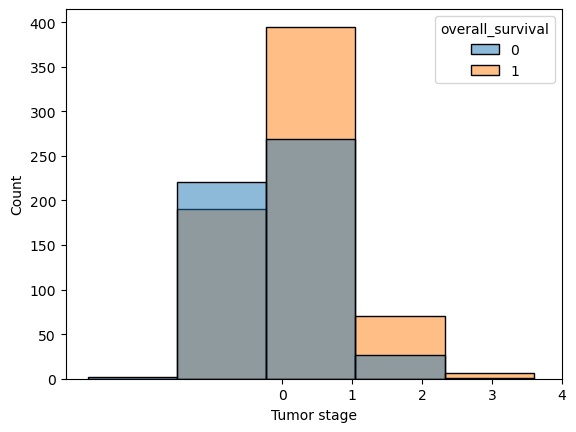

In [532]:
#histplot
sns.histplot(data=df, x='tumor_stage', bins=5, hue='overall_survival')
plt.xlabel('Tumor stage')
plt.xticks([0,1,2,3,4]);

Text(0.5, 0, 'Nottingham index')

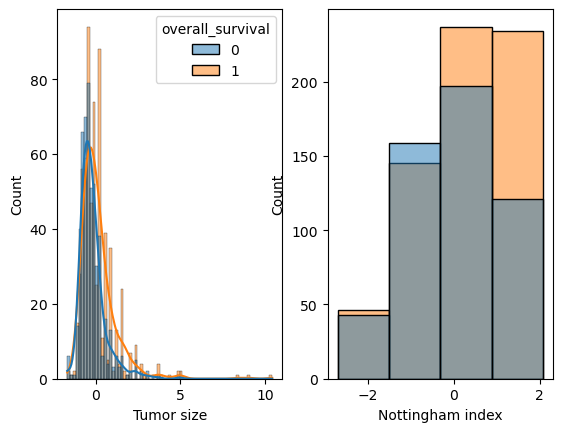

In [533]:
plt.subplot(1,2,1)
sns.histplot(data=df, x='tumor_size',hue='overall_survival', kde=True)
plt.xlabel('Tumor size')
plt.subplot(1,2,2)
sns.histplot(data=df, x='nottingham_prognostic_index',hue='overall_survival',bins=4,legend=False)
plt.xlabel('Nottingham index')

### Feature correlation to patient mortality

In [534]:
print('Top 15 features correlated with death:')
df.corr(numeric_only=True)['overall_survival'].sort_values()[:15]

Top 15 features correlated with death:


cdkn2c                          -0.211885
hsd17b11                        -0.207751
jak1                            -0.193702
casp8                           -0.187504
myc                             -0.179950
lama2                           -0.178204
cohort_1.0                      -0.177976
inferred_menopausal_state_Pre   -0.177439
spry2                           -0.171490
stat5a                          -0.161958
tgfbr2                          -0.160153
igf1                            -0.159679
kit                             -0.154889
rheb                            -0.153300
mapk14                          -0.152612
Name: overall_survival, dtype: float64

In [535]:
print('Top 10 features correlated with survival:')
df.corr(numeric_only=True)['overall_survival'].sort_values(ascending=False)[:15]

Top 10 features correlated with survival:


overall_survival                     1.000000
age_at_diagnosis                     0.309256
cohort_3.0                           0.210642
tumor_size                           0.170795
ncoa3                                0.169430
type_of_breast_surgery_MASTECTOMY    0.169163
lymph_nodes_examined_positive        0.168063
tumor_stage                          0.167757
gsk3b                                0.167004
kmt2c                                0.154626
tsc2                                 0.148509
nottingham_prognostic_index          0.147213
maml1                                0.137035
akt1                                 0.135464
afdn                                 0.134755
Name: overall_survival, dtype: float64

## Predicting patient mortality
### Test and train sets


In [536]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train, y_train = train_set.drop(columns=['overall_survival']), train_set['overall_survival']
X_test, y_test = test_set.drop(columns=['overall_survival']), test_set['overall_survival']

### Building classfication models

Several models were optimized manually. This includes three logistic regression models using ridge, lasso, and elastic net regularization techniques; two support vector machines classification models using linear and sigmoid kerels (the sigmoid kernel was the best performing non-linear model); a random forest model; and an extra trees model. The best performing model of each type was selected for further performance analysis.

In [537]:


#selecting models 
log_mod = LogisticRegression(max_iter=10000,random_state=10, C=0.01).fit(X_train, y_train) 
lasso_mod = LogisticRegression(max_iter=1000,penalty='l1',C=.15,solver='saga',random_state=10).fit(X_train, y_train)
elastic_mod = LogisticRegression(max_iter=10000,C=.2,penalty='elasticnet',l1_ratio=0.2,solver='saga', random_state=10).fit(X_train, y_train)
svm_mod = LinearSVC(random_state=10,max_iter=10000, C=.001).fit(X_train, y_train)
svm_kernel = SVC(kernel='sigmoid', random_state=10, max_iter=10000, gamma='scale').fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=700,random_state=10, ).fit(X_train,y_train)
et = ExtraTreesClassifier(n_estimators=700, random_state=10).fit(X_train, y_train)

models = [log_mod,lasso_mod,elastic_mod,svm_mod,svm_kernel, rf, et]
#models = [elastic_mod, svm_kernel, rf, et]
model_names = [type(model).__name__ for model in models]

#scoring models
accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

for model in models:
    y_predict = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_predict))
    precision.append(precision_score(y_test, y_predict))
    f1.append(f1_score(y_test, y_predict))
    roc_auc.append(roc_auc_score(y_test, y_predict))
    recall.append(recall_score(y_test, y_predict))

scores = pd.DataFrame([accuracy, precision, recall, f1, roc_auc],columns=model_names,index=['accuracy','precision','recall','f1','roc_auc']).T

In [538]:
scores

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.721519,0.730496,0.786260,0.757353,0.713884
LogisticRegression,0.704641,0.719424,0.763359,0.740741,0.697717
LogisticRegression,0.704641,0.736434,0.725191,0.730769,0.702218
LinearSVC,0.729958,0.737589,0.793893,0.764706,0.722418
SVC,0.721519,0.724138,0.801527,0.760870,0.712084
RandomForestClassifier,0.704641,0.680473,0.877863,0.766667,0.684214
ExtraTreesClassifier,0.721519,0.709677,0.839695,0.769231,0.707583


In [637]:
'''
ax = scores.sort_values('accuracy', ascending=False).T.plot(kind='bar')
plt.ylim((0,1.1))
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Model scores');
'''

"\nax = scores.sort_values('accuracy', ascending=False).T.plot(kind='bar')\nplt.ylim((0,1.1))\nax.legend(loc='center left', bbox_to_anchor=(1,0.5))\nplt.title('Model scores');\n"

In [540]:
'''
#scoring models
accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

for model in models:
    cal_mod = CalibratedClassifierCV(model,cv='prefit')
    cal_mod.fit(X_train, y_train)
    y_scores = cal_mod.predict_proba(X_test)[:,1] #https://scikit-learn.org/stable/modules/calibration.html

    y_predict = model.predict(X_test)
    accuracy.append(accuracy_score(y_predict,y_test))
    precision.append(precision_score(y_predict, y_test))
    f1.append(f1_score(y_predict, y_test))
    roc_auc.append(roc_auc_score(y_predict, y_test))
    recall.append(recall_score(y_predict, y_test))

cal_scores = pd.DataFrame([accuracy, precision, recall, f1, roc_auc],columns=model_names,index=['accuracy','precision','recall','f1','roc_auc']).T
cal_scores - scores
'''


"\n#scoring models\naccuracy = []\nprecision = []\nrecall = []\nf1 = []\nroc_auc = []\n\nfor model in models:\n    cal_mod = CalibratedClassifierCV(model,cv='prefit')\n    cal_mod.fit(X_train, y_train)\n    y_scores = cal_mod.predict_proba(X_test)[:,1] #https://scikit-learn.org/stable/modules/calibration.html\n\n    y_predict = model.predict(X_test)\n    accuracy.append(accuracy_score(y_predict,y_test))\n    precision.append(precision_score(y_predict, y_test))\n    f1.append(f1_score(y_predict, y_test))\n    roc_auc.append(roc_auc_score(y_predict, y_test))\n    recall.append(recall_score(y_predict, y_test))\n\ncal_scores = pd.DataFrame([accuracy, precision, recall, f1, roc_auc],columns=model_names,index=['accuracy','precision','recall','f1','roc_auc']).T\ncal_scores - scores\n"

In [541]:
select_scores = scores.reset_index().drop([1,2,4]).set_index('index')
select_scores

,accuracy,precision,recall,f1,roc_auc
index,,,,,
LogisticRegression,0.721519,0.730496,0.786260,0.757353,0.713884
LinearSVC,0.729958,0.737589,0.793893,0.764706,0.722418
RandomForestClassifier,0.704641,0.680473,0.877863,0.766667,0.684214
ExtraTreesClassifier,0.721519,0.709677,0.839695,0.769231,0.707583


In [542]:
from operator import itemgetter

selected_models = itemgetter(0,3,5,6)(models)
print('Selected model details:')
selected_models

Selected model details:


(LogisticRegression(C=0.01, max_iter=10000, random_state=10),
 LinearSVC(C=0.001, max_iter=10000, random_state=10),
 RandomForestClassifier(n_estimators=700, random_state=10),
 ExtraTreesClassifier(n_estimators=700, random_state=10))

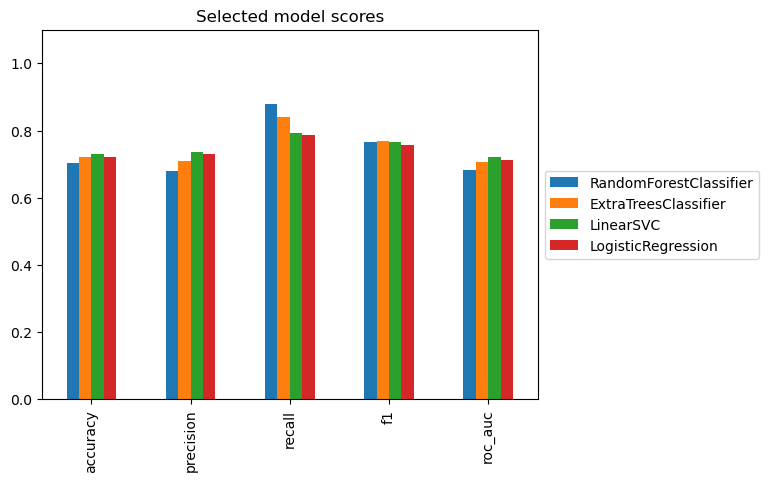

In [543]:
ax = select_scores.sort_values('recall', ascending=False).T.plot(kind='bar')
plt.ylim((0,1.1))
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Selected model scores');

Although a model may be able to predict probabilities, the distribution and behavior of the probabilities may not match the expected distribution of observed probabilities in the training data.

This is especially common with complex nonlinear machine learning algorithms that do not directly make probabilistic predictions and instead use approximations.

The distribution of the probabilities can be adjusted to better match the expected distribution observed in the data. This adjustment is referred to as calibration, as in the calibration of the model or the calibration of the distribution of class probabilities.

### Evaluating models

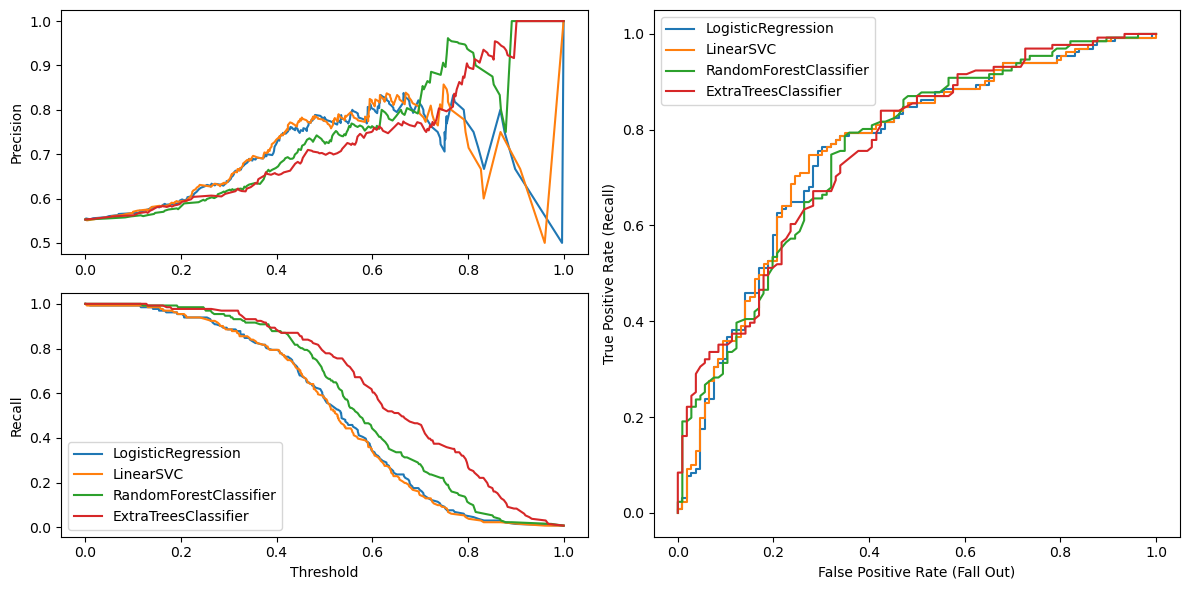

In [544]:
 fig = plt.figure(figsize=(12,6))
for model in selected_models:
    #getting scores
    try:
      y_scores = model.decision_function(X_test)
    except:
      y_scores = model.predict_proba(X_test)[:,1]
       
    #cal_mod = CalibratedClassifierCV(model,cv='prefit')
    #cal_mod.fit(X_train, y_train)
    #y_scores = cal_mod.predict_proba(X_test)[:,1] #https://scikit-learn.org/stable/modules/calibration.html

    #calculating precision, recall, false positive rate, true positive rate, and normalizing thresholds
    fpr,tpr,thresholds=roc_curve(y_test, y_scores)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    thresholds = (thresholds-min(thresholds))/(max(thresholds)-min(thresholds)) #rescale all thresholds

    #plotitng precision
    plt.subplot(2,2,1)
    plt.plot(thresholds, precisions[:-1],label=type(model).__name__)
    plt.ylabel('Precision')

    #plotting recall
    plt.subplot(2,2,3)
    plt.plot(thresholds, recalls[:-1],label=type(model).__name__)
    plt.ylabel("Recall")
    plt.xlabel("Threshold")
    plt.legend()

    #plotting ROC
    plt.subplot(1,2,2)
    plt.plot(fpr,tpr,label=type(model).__name__)
    plt.xlabel('False Positive Rate (Fall Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()

plt.tight_layout()
    

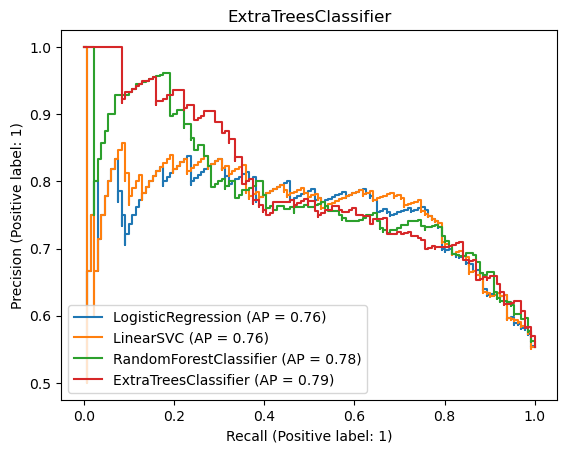

In [545]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(1)
for model in selected_models:
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax = ax)
    plt.title(type(model).__name__)

### Stacking classifiers

In [546]:
select_scores

,accuracy,precision,recall,f1,roc_auc
index,,,,,
LogisticRegression,0.721519,0.730496,0.786260,0.757353,0.713884
LinearSVC,0.729958,0.737589,0.793893,0.764706,0.722418
RandomForestClassifier,0.704641,0.680473,0.877863,0.766667,0.684214
ExtraTreesClassifier,0.721519,0.709677,0.839695,0.769231,0.707583


In [579]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

stacking_clf = StackingClassifier([
    ('lr', selected_models[0]),
    ('svc', selected_models[1]),
    #('rf', selected_models[2]),
    ('et', selected_models[3])
],
final_estimator= LogisticRegression(random_state=10)
)

In [580]:
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7341772151898734

In [563]:
voting_clf = VotingClassifier(estimators=[
    ('lr', selected_models[0]),
    #('svc', selected_models[1]),
    ('rf', selected_models[2]),
    ('et', selected_models[3])
]
)

In [564]:
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.729957805907173

 Average precision computes the average precision value for recall value over 0 to 1

## Feature imporance: Genes and mutations

In [551]:
#Identifying gene and mutation data in df
#count = 0 
#for col in df.columns:
#    print(col, count)
#    count += 1

#gene data in cols 6-494
#mutant data in cols 500-554
gene_start = 5
gene_stop = 494
mutant_start=498
mutant_stop=553

In [552]:
def feature_importance(model, X_test, y_test):
    baseline_y = model.predict(X_test)
    baseline = accuracy_score(y_test, baseline_y)
    f_imp = []
        
    for col in X_test.columns:
        save = copy.deepcopy(X_test[col])
        X_test[col] = np.random.permutation(X_test[col])

        y_perm = model.predict(X_test)
        perm_baseline = accuracy_score(y_test, y_perm)
        f_imp.append(baseline-perm_baseline)
        
        X_test[col] = save #resets permuted values
        
    return f_imp

In [626]:
f_imp = pd.DataFrame(data=selected_models[1].coef_.T, index=X_test.columns.values)
f_imp.sort_values(0,ascending=False).head(20)

,0
age_at_diagnosis,0.154568
lymph_nodes_examined_positive,0.084995
type_of_breast_surgery_MASTECTOMY,0.059369
tumor_size,0.056251
rad50,0.047286
bche,0.042969
alk,0.041876
ncoa3,0.039806
smarcd1,0.038851
cohort_3.0,0.038427


In [630]:
stacking_f_imp = feature_importance(selected_models[1], X_test, y_test)
stacking_f_imp = pd.DataFrame(data=stacking_f_imp, index=X_test.columns.values)
stacking_f_imp = stacking_f_imp[stacking_f_imp!=0].dropna()
stacking_f_imp.sort_values(0,ascending=False).head(20)

,0
age_at_diagnosis,0.054852
dnah2,0.033755
bmp10,0.025316
cxcl8,0.025316
smad9,0.021097
nottingham_prognostic_index,0.021097
ryr2,0.021097
tgfb3,0.021097
afdn,0.021097
prkcq,0.021097


In [636]:
from sklearn.inspection import permutation_importance
results = permutation_importance(selected_models[1], X_test, y_test, scoring='accuracy')
pd.DataFrame(data=results.importances_mean, index=X_test.columns.values).sort_values(0,ascending=False).head(20)

,0
age_at_diagnosis,0.040506
cxcl8,0.021097
rptor,0.021097
wfdc2,0.020253
sbno1,0.016878
smad3,0.016878
cdkn2b,0.016034
terc,0.016034
pdpk1,0.015190
nf2,0.015190


In [627]:
f_clinical = stacking_f_imp[:gene_start].append(f_imp[mutant_stop:]).append(f_imp[gene_stop:mutant_start])
f_clinical.sort_values(0, ascending=False).head(10)

C:\Users\corne\AppData\Local\Temp\ipykernel_8260\3511751545.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_clinical = stacking_f_imp[:gene_start].append(f_imp[mutant_stop:]).append(f_imp[gene_stop:mutant_start])
C:\Users\corne\AppData\Local\Temp\ipykernel_8260\3511751545.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_clinical = stacking_f_imp[:gene_start].append(f_imp[mutant_stop:]).append(f_imp[gene_stop:mutant_start])


,0
type_of_breast_surgery_MASTECTOMY,0.059369
cohort_3.0,0.038427
age_at_diagnosis,0.025316
tumor_other_histologic_subtype_Mixed,0.024204
oncotree_code_MDLC,0.024204
cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma,0.024204
her2_status_measured_by_snp6_NEUTRAL,0.019622
mutation_count,0.018666
3-gene_classifier_subtype_ER+/HER2- High Prolif,0.013877
pam50_+_claudin-low_subtype_Her2,0.013046


In [597]:
f_genes = stacking_f_imp[gene_start:gene_stop].sort_values(0, ascending=False)
#f_genes = f_genes[abs(f_genes)>.001].dropna()
f_genes.head(10)

,0
bbc3,0.029536
afdn,0.025316
smad3,0.021097
taf1,0.021097
bmp7,0.021097
rptor,0.021097
e2f6,0.021097
nrip1,0.021097
bmp4,0.016878
myo3a,0.016878


In [598]:
f_mutants = stacking_f_imp[mutant_start:mutant_stop].sort_values(0, ascending=False)
#f_mutants = f_mutants[abs(f_mutants)>0.001].dropna()
f_mutants.head(10)

,0
tp53_mut,0.004219
thada_mut,0.004219
rb1_mut,0.004219
pik3ca_mut,NaN
muc16_mut,NaN
ahnak2_mut,NaN
kmt2c_mut,NaN
syne1_mut,NaN
gata3_mut,NaN
map3k1_mut,NaN


<Axes: title={'center': 'Feature Importance by permutation'}, ylabel='Decrease in accuracy'>

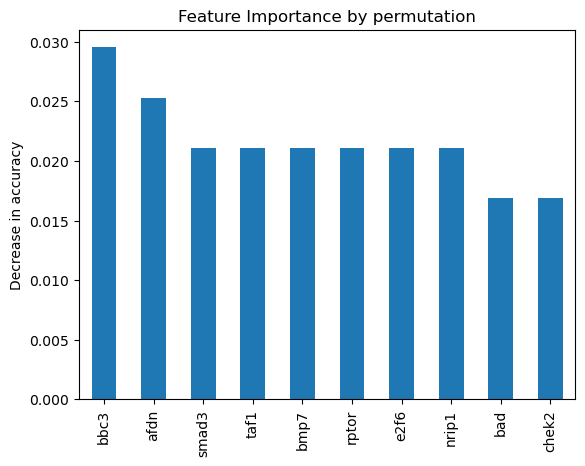

In [599]:
f_genes.sort_values(0, ascending=False)[:10].plot(kind='bar',ylabel = 'Decrease in accuracy', title='Feature Importance by permutation',legend=False)



<Axes: title={'center': 'Feature Importance by permutation'}, ylabel='Decrease in accuracy'>

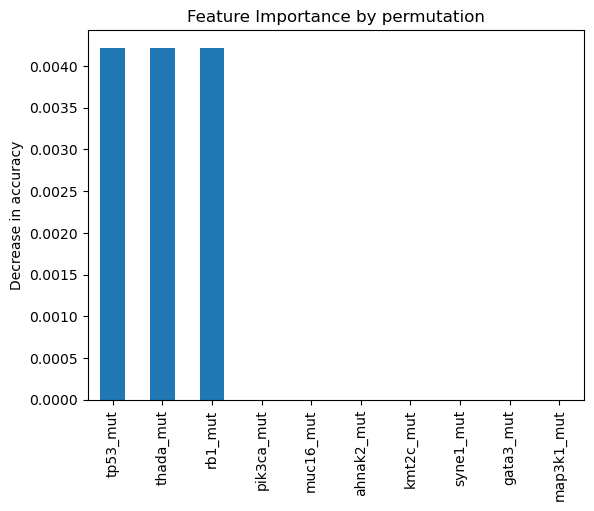

In [600]:
f_mutants.sort_values(0, ascending=False)[:10].plot(kind='bar',ylabel = 'Decrease in accuracy', title='Feature Importance by permutation',legend=False)


<Axes: title={'center': 'Feature Importance by permutation'}, ylabel='Decrease in accuracy'>

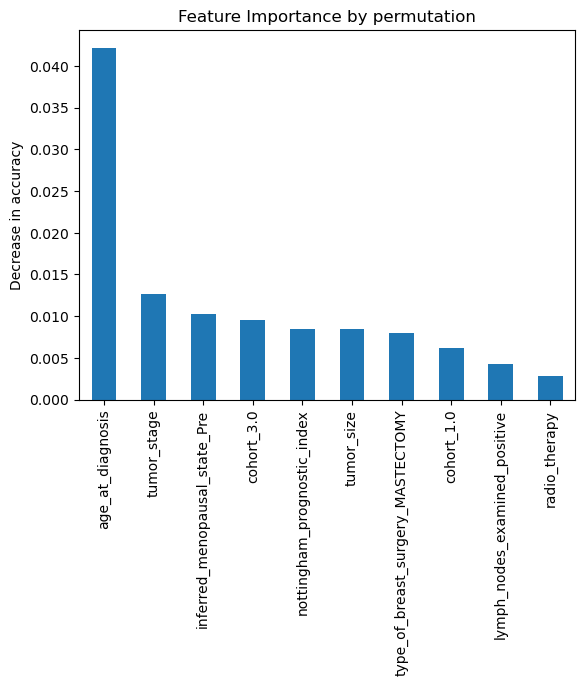

In [601]:
f_clinical.sort_values(0, ascending=False)[:10].plot(kind='bar',ylabel = 'Decrease in accuracy', title='Feature Importance by permutation',legend=False)